In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [4]:
def trend(time , slope = 0): # trend is data's feature 
    return slope * time 

def seasonal_pattern(season_time): # generate pattern by season_time(numpy ndarray)
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time)) 

def seasonality(time, period, amplitude=1 , phase=0): # make a seasonal pattern using seasonal_pattern function.
    season_time = ((time + phase) % period) / period  # You define ndarray season_time 
    return amplitude * seasonal_pattern(season_time) 

def noise(time, noise_level=1, seed=None): # generate noise in order to make synthetic data
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level 

def plot_series(time, series, format="-", title="", label=None, start=0, end = None):
    plt.plot(time[start:end], series[start:end], format, label= label)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("series")
    if label:
        plt.legend() # display a what kind of data is plotted (설명창 = 범례)
    plt.grid(True)

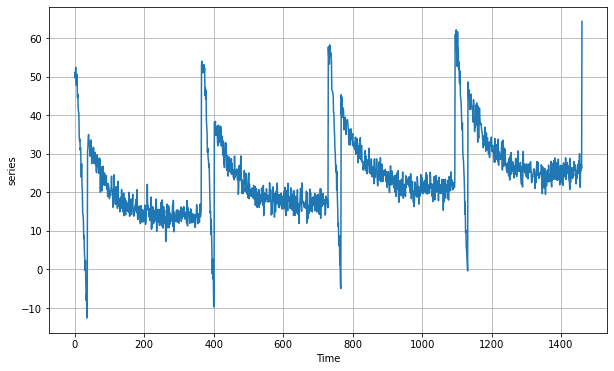

In [5]:
TIME = np.arange(4 * 365 + 1, dtype="float32")

y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)


plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

In [6]:
SPLIT_TIME = 1100

def train_val_split(time, series, time_step=SPLIT_TIME): # make train and valid data

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]


    return time_train, series_train, time_valid, series_valid

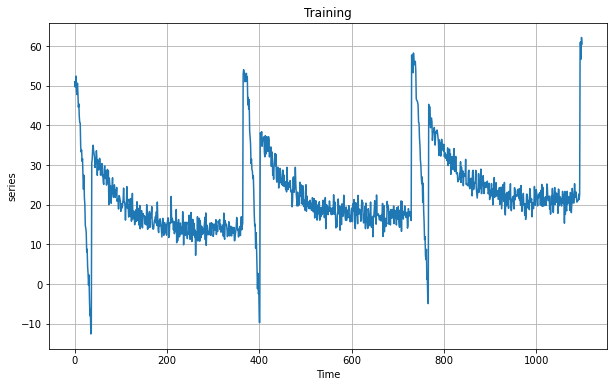

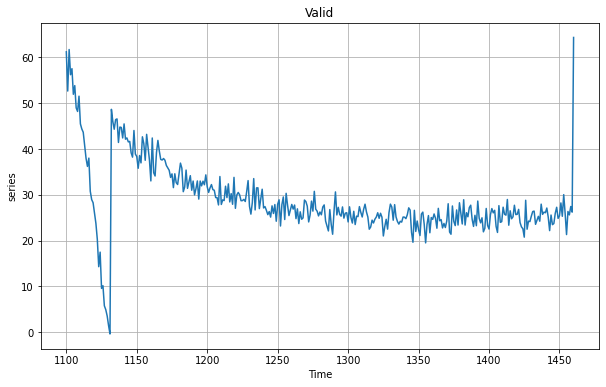

In [7]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Valid")
plt.show()

In [8]:
def compute_metrics(true_series, forecast): # milestone metric

    mse = np.square(forecast-true_series).mean()
    mae = np.abs(forecast-true_series).mean()


    return mse, mae

naive forecast should be the baseline of our forecast problem. <br>
So, if naive error is 2.6 , moving average method 's error should be lower then 2.6 to be logically better.

In [9]:
def moving_average_forecast(series, window_size):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean()) # append the centered average value 
        
    np_forecast = np.array(forecast) # convert into numpy.ndarray 
    
    return np_forecast

moving average forecast with whole SERIES has shape: (1431,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True


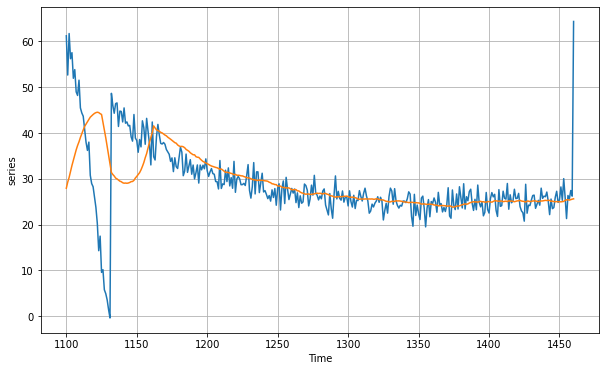

In [10]:
moving_avg = moving_average_forecast(SERIES, window_size=30)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}\n")

moving_avg = moving_avg[1100 - 30:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

## Differencing is a method to use moving average values . <br>
Also from data we eliminate trend and seasonality values and use the difference between current value and specific period value. <br> Since we extract from it, trend and seasonality is also gone.

Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)



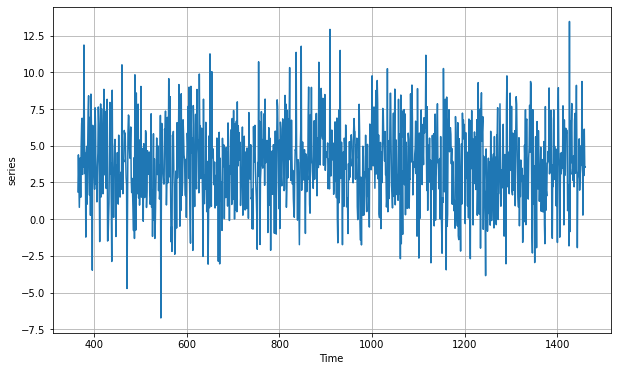

In [11]:
diff_series =(SERIES[365:] - SERIES[:-365])
diff_time =TIME[365:]


print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements\n")
print(f"diff series has shape: {diff_series.shape}\n")
print(f"x-coordinate of diff series has shape: {diff_time.shape}\n")

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

moving average forecast with diff series has shape: (1046,)

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


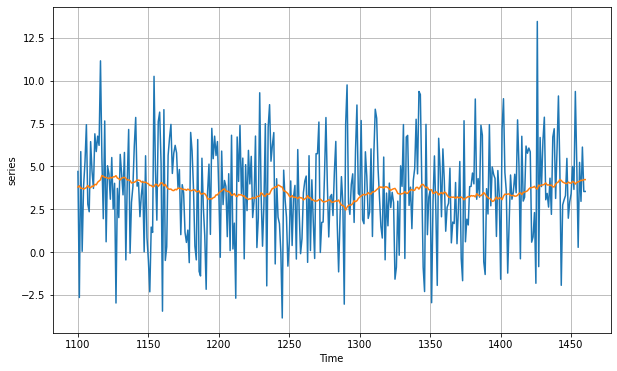

In [12]:
diff_moving_avg = moving_average_forecast(diff_series, 50)

print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

diff_moving_avg = diff_moving_avg[1100 -365 -50:]

print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")


plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


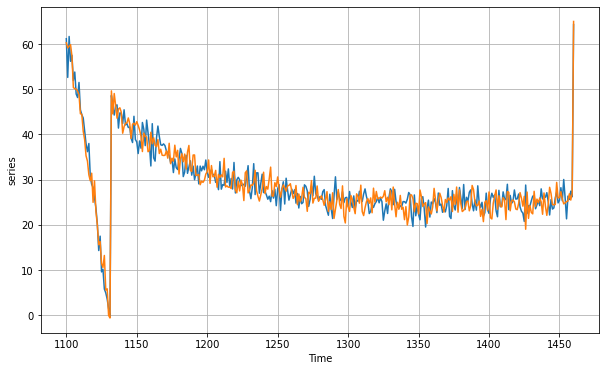

In [13]:
past_series = SERIES[SPLIT_TIME - 365:-365] 

print(f"past series has shape: {past_series.shape}\n")

diff_moving_avg_plus_past = past_series + diff_moving_avg # so, if we are goind to add subtracted past series


print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

#### However , there is some noise. So in order to solve this we are going to add the moving average of past series 

smooth past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


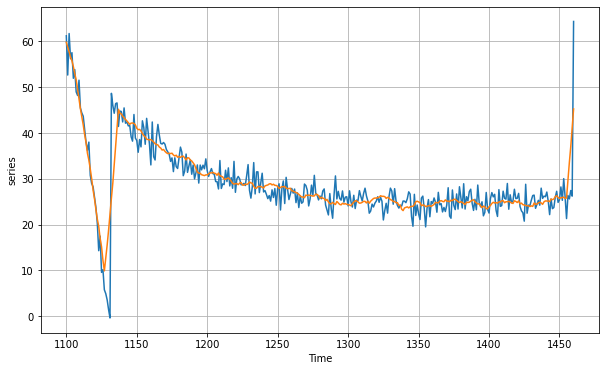

In [14]:
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME - 370:-360], 10)

print(f"smooth past series has shape: {smooth_past_series.shape}\n")

diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg


print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [17]:
print(compute_metrics(series_valid,diff_moving_avg_plus_smooth_past)) # 2.2 - much lower

(12.527958, 2.2034435)
